In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [4]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
#image to tensor
transform = transforms.ToTensor()

In [7]:
train_data = datasets.MNIST(root='../data',train=True, download=True, transform=transform)

In [11]:
test_data = datasets.MNIST(root='../data',train=False,download=True, transform= transform)

In [12]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data
    Split: Train

In [13]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../data
    Split: Test

In [14]:
type(train_data)

torchvision.datasets.mnist.MNIST

In [18]:
train_data[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [20]:
image, label = train_data[0]

In [21]:
image.shape #color channel, col, row

torch.Size([1, 28, 28])

In [22]:
label

5

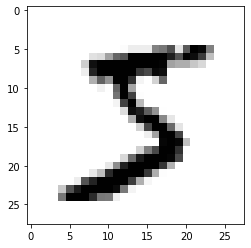

In [25]:
plt.imshow(image.reshape(28,28),cmap='gist_yarg')

In [26]:
torch.manual_seed(101)

# 0 images, 1 images....
train_loader = DataLoader(train_data, batch_size=100, shuffle=True)
test_loader = DataLoader(test_data,batch_size=500, shuffle=False)

In [27]:
from torchvision.utils import make_grid
np.set_printoptions(formatter=dict(int=lambda x : f'{x:4}')) #formatting

In [28]:
#first batch
for images,labels in train_loader:
    break

In [30]:
images.shape

torch.Size([100, 1, 28, 28])

In [32]:
labels.shape

torch.Size([100])

Labels: [   0    5    7    8    6    7    9    7    1    3    8    4]


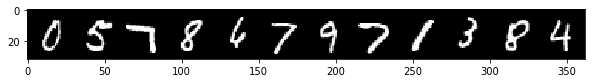

In [33]:
print('Labels:', labels[:12].numpy())
im = make_grid(images[:12],nrow=12)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(),(1,2,0))) # color, width, height -> whc

In [42]:
class MultilayerPerceptron(nn.Module):
    def __init__(self, in_sz = 784, out_sz = 10,layers=[120,84]):
        super().__init__()
        
        self.fc1 = nn.Linear(in_sz,layers[0])
        self.fc2 = nn.Linear(layers[0],layers[1])
        self.fc3 = nn.Linear(layers[1],out_sz)
        
    def forward(self,X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        
        return F.log_softmax(X, dim = 1) #multicalss classification

In [43]:
torch.manual_seed(101)
model = MultilayerPerceptron()
model

MultilayerPerceptron(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [44]:
# ann to cnn
for param in model.parameters():
    print(param.numel())

94080
120
10080
84
840
10


In [45]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [47]:
images.view(100,-1) # 100,1,28,28 -> 100,784

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [50]:
import time
start_time = time.time()

#training
epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    for b, (X_train,y_train) in enumerate(train_loader):#image/label
        b+=1 #index
        y_pred = model(X_train.view(100,-1))
        loss = criterion(y_pred, y_train)
        
        predicted = torch.max(y_pred.data,1)[1] 
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%200==0:
            acc = trn_corr.item() * 100 / (100*b)
            print(f'epoch {i} batch {b} loss : {loss.item()} acc : {acc}')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
    
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test.view(500,-1))
            predicted = torch.max(y_val.data,1)[1]
            tst_corr += (predicted== y_test).sum()
            
    loss = criterion(y_val,y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
total_time = time.time() - start_time
print(f'Duration : {total_time/60}mins')

epoch 0 batch 200 loss : 0.21371108293533325 acc : 92.255
epoch 0 batch 400 loss : 0.11332173645496368 acc : 92.9725
epoch 0 batch 600 loss : 0.07010617107152939 acc : 93.57333333333334
epoch 1 batch 200 loss : 0.1742822229862213 acc : 95.78
epoch 1 batch 400 loss : 0.06903845071792603 acc : 95.885
epoch 1 batch 600 loss : 0.036128878593444824 acc : 95.98166666666667
epoch 2 batch 200 loss : 0.031315457075834274 acc : 96.935
epoch 2 batch 400 loss : 0.06764055043458939 acc : 97.0075
epoch 2 batch 600 loss : 0.015972130000591278 acc : 97.04333333333334
epoch 3 batch 200 loss : 0.11932879686355591 acc : 97.685
epoch 3 batch 400 loss : 0.11064671725034714 acc : 97.7225
epoch 3 batch 600 loss : 0.09186309576034546 acc : 97.74666666666667
epoch 4 batch 200 loss : 0.04529161378741264 acc : 98.035
epoch 4 batch 400 loss : 0.06850722432136536 acc : 98.1575
epoch 4 batch 600 loss : 0.041590616106987 acc : 98.08666666666667
epoch 5 batch 200 loss : 0.017677174881100655 acc : 98.525
epoch 5 batch

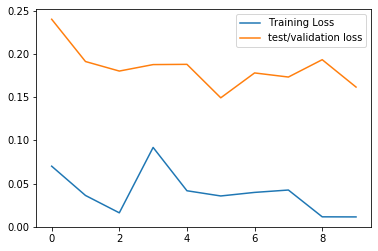

In [59]:
plt.plot(train_losses,label='Training Loss')
plt.plot(test_losses, label='test/validation loss')
plt.legend()

In [62]:
train_acc = [t/600 for t in train_correct]

In [64]:
test_acc = [t/100 for t in test_correct]

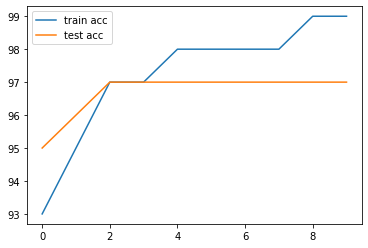

In [66]:
plt.plot(train_acc,label='train acc')
plt.plot(test_acc , label='test acc')
plt.legend()

In [67]:
#new unseen data
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [68]:
with torch.no_grad():
    correct = 0
    
    for X_test, y_test in test_load_all:
        y_val = model(X_test.view(len(X_test),-1))
        predicted = torch.max(y_val,1)[1]
        correct += (predicted==y_test).sum()

In [72]:
100*correct.item()/len(test_data)

97.8

In [73]:
confusion_matrix(predicted.view(-1),y_test.view(-1))

array([[ 965,    0,    4,    0,    1,    2,    4,    0,    4,    2],
       [   0, 1125,    3,    0,    0,    0,    3,    6,    0,    2],
       [   3,    1, 1007,    2,    2,    0,    1,    7,    2,    0],
       [   1,    1,    4,  993,    1,    5,    1,    4,    7,    7],
       [   0,    0,    1,    0,  954,    2,    5,    0,    1,    6],
       [   1,    0,    0,    7,    0,  872,    7,    0,    6,    2],
       [   1,    2,    2,    0,    3,    4,  934,    0,    1,    0],
       [   2,    1,    6,    4,    2,    2,    1, 1001,    4,    5],
       [   4,    5,    4,    1,    2,    4,    2,    3,  947,    3],
       [   3,    0,    1,    3,   17,    1,    0,    7,    2,  982]],
      dtype=int64)

In [97]:
from sklearn.metrics import roc_auc_score
t1 = np.array(y_test)
t2 = np.array(predicted)
confusion_matrix(t1,t2)

array([[ 965,    0,    3,    1,    0,    1,    1,    2,    4,    3],
       [   0, 1125,    1,    1,    0,    0,    2,    1,    5,    0],
       [   4,    3, 1007,    4,    1,    0,    2,    6,    4,    1],
       [   0,    0,    2,  993,    0,    7,    0,    4,    1,    3],
       [   1,    0,    2,    1,  954,    0,    3,    2,    2,   17],
       [   2,    0,    0,    5,    2,  872,    4,    2,    4,    1],
       [   4,    3,    1,    1,    5,    7,  934,    1,    2,    0],
       [   0,    6,    7,    4,    0,    0,    0, 1001,    3,    7],
       [   4,    0,    2,    7,    1,    6,    1,    4,  947,    2],
       [   2,    2,    0,    7,    6,    2,    0,    5,    3,  982]],
      dtype=int64)

In [111]:
t1.astype('int32')

array([   7,    2,    1, ...,    4,    5,    6])

In [115]:
t2.astype('int32')

array([   7,    2,    1, ...,    4,    5,    6])

In [116]:
import numpy as np
from sklearn.metrics import roc_auc_score
y_true = np.array([0, 0, 1, 1])
y_scores = np.array([0.1, 0.4, 0.35, 0.8])
roc_auc_score(t1, t2)

ValueError: multi_class must be in ('ovo', 'ovr')

In [117]:
y_true.dtype

dtype('int32')

In [118]:
y_scores.dtype

dtype('float64')

In [114]:
y_true

array([   0,    0,    1,    1])

In [119]:
y_scores

array([0.1 , 0.4 , 0.35, 0.8 ])